<a href="https://colab.research.google.com/github/rakshitgupta22/human-AI-text/blob/main/AI_Human_Detector_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
#Loading the raw dataset
chatgpt_responses = pd.read_csv("/content/drive/MyDrive/RA/chatgpt_responses.tsv", sep="\t", engine='c', names=['ID', 'text'])
human_responses = pd.read_csv("/content/drive/MyDrive/RA/human_responses.tsv", sep="\t", names=['ID', 'text'])

In [ ]:
chatgpt_responses.shape

(26882, 2)

In [ ]:
human_responses.shape

(58546, 2)

In [ ]:
#create lael column
chatgpt_responses['label'] = 1
human_responses['label'] = 0

In [ ]:
#Use 15000 texts from each to create a balanced dataset for model training and testing
data = pd.concat([chatgpt_responses[:15000], human_responses[:15000]], axis=0)

In [ ]:
data.shape

(30000, 3)

In [ ]:
data.head()

,ID,text,label
0,0_C_0,There are many different best seller lists tha...,1
1,1_C_0,Salt is used on roads to help melt ice and sno...,1
2,2_C_0,There are a few reasons why we still have SD (...,1
3,3_C_0,It is generally not acceptable or ethical to a...,1
4,4_C_0,After the Wright Brothers made the first power...,1


In [ ]:
data.isnull().sum()

ID       0
text     0
label    0
dtype: int64

In [ ]:
data.label.value_counts()

1    15000
0    15000
Name: label, dtype: int64

In [ ]:
data['text_words'] = data['text'].apply(lambda x: x.split(" "))

In [ ]:
data['text_len'] = data['text_words'].apply(lambda x: len(x))

In [ ]:
data.head()

,ID,text,label,text_words,text_len
0,0_C_0,There are many different best seller lists tha...,1,"[There, are, many, different, best, seller, li...",207
1,1_C_0,Salt is used on roads to help melt ice and sno...,1,"[Salt, is, used, on, roads, to, help, melt, ic...",199
2,2_C_0,There are a few reasons why we still have SD (...,1,"[There, are, a, few, reasons, why, we, still, ...",146
3,3_C_0,It is generally not acceptable or ethical to a...,1,"[It, is, generally, not, acceptable, or, ethic...",145
4,4_C_0,After the Wright Brothers made the first power...,1,"[After, the, Wright, Brothers, made, the, firs...",199


In [ ]:
import matplotlib.pyplot as plt

<Axes: >

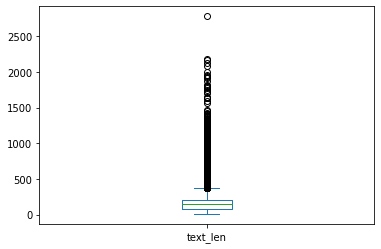

In [ ]:
data['text_len'].plot(kind = 'box')

In [ ]:
#Visualizing text length to select an optimal value of max_length parameter in BERT
data['text_len'].describe()

count    30000.000000
mean       157.469533
std        131.989346
min          8.000000
25%         81.000000
50%        144.000000
75%        199.000000
max       2783.000000
Name: text_len, dtype: float64

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.4 MB/s eta 0:00:00


In [ ]:
#importing required packages
from transformers import (
    RobertaForSequenceClassification,
    RobertaTokenizer)

from torch.optim import AdamW

In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Loading RoBERTa base model
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", #RoBERTa base model
                                                                    num_labels = 2,  #number of output labels - 0,1 (binary classification)
                                                                    output_attentions = True,  #model doesnt return attention weights
                                                                    output_hidden_states = False #model doesnt return hidden states
                                                                )
#RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
roberta_model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
from sklearn.model_selection import train_test_split
# X = data[['text']]
# Y = data[['label']]

data_train, data_test = train_test_split(data, test_size = 0.2, stratify = data['label'],random_state=0)
data_valid, data_test = train_test_split(data_test, test_size = 0.5, stratify = data_test['label'], random_state=0)

In [ ]:
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(24000, 5)
(3000, 5)
(3000, 5)


In [ ]:
print(data_train['label'].value_counts())
print(data_valid['label'].value_counts())
print(data_test['label'].value_counts())

1    12000
0    12000
Name: label, dtype: int64
0    1500
1    1500
Name: label, dtype: int64
0    1500
1    1500
Name: label, dtype: int64


In [ ]:
# Below function performs tokenization process as required by bert and roberta models, for a given dataset
def bert_robert_tokenization(dataset):
  sentences = dataset["text"].values
  labels = dataset["label"].values
  max_length = 256

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  bert_input_ids = []
  bert_attention_masks = []
  roberta_input_ids = []
  roberta_attention_masks = []

  sentence_ids = []
  counter = 0

  # For every sentence...
  for sent in sentences:
      #encode_plus function will encode the sentences as required by model, including tokenization process and mapping token ids

      roberta_encoded_dict = roberta_tokenizer.encode_plus(
                          str(sent),        #sentence
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens
                          max_length = 256,        #Since we have seen from our analysis that majority of sentences have length less than 300.
                          padding = 'max_length',     # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,   # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )


      # Add the encoded sentence to the list.
      roberta_input_ids.append(roberta_encoded_dict['input_ids'])
      #roberta_input_ids.append(roberta_encoded_dict['input_ids'])


      # Add attention mask to the list
      roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
      #roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])


      # collecting sentence_ids
      sentence_ids.append(counter)
      counter  = counter + 1



  # Convert the lists into tensors.
  roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
  roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)


  labels = torch.tensor(labels)
  sentence_ids = torch.tensor(sentence_ids)

  return {#"Bert":[bert_input_ids, bert_attention_masks, labels],
          "Roberta":[roberta_input_ids, roberta_attention_masks, labels]
          }

In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

#tokenizing train set
token_dict_train = bert_robert_tokenization(data_train)

# bert_input_ids,bert_attention_masks,labels = token_dict_train["Bert"]
roberta_input_ids, roberta_attention_masks, labels = token_dict_train["Roberta"]

#tokenizing validation set
token_dict_valid = bert_robert_tokenization(data_valid)

# bert_input_ids_valid,bert_attention_masks_valid,labels_valid = token_dict_valid["Bert"]
roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid = token_dict_valid["Roberta"]

#tokenizing test set
token_dict_test = bert_robert_tokenization(data_test)

# bert_input_ids_test,bert_attention_masks_test,labels_test = token_dict_test["Bert"]
roberta_input_ids_test, roberta_attention_masks_test, labels_test = token_dict_test["Roberta"]

In [ ]:
# Combine the training inputs into a TensorDataset.
# bert_train_dataset = TensorDataset( bert_input_ids, bert_attention_masks, labels)
roberta_train_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

# Combine the validation inputs into a TensorDataset.
# bert_val_dataset = TensorDataset(bert_input_ids_valid,bert_attention_masks_valid,labels_valid)
roberta_val_dataset = TensorDataset(roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid)

# Combine the test inputs into a TensorDataset.
# bert_test_dataset = TensorDataset(bert_input_ids_test,bert_attention_masks_test,labels_test)
roberta_test_dataset = TensorDataset(roberta_input_ids_test, roberta_attention_masks_test, labels_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training - Loads the data randomly in batches of size 32
# bert_train_dataloader = DataLoader(
#             bert_train_dataset,  # The training samples.
#             sampler = RandomSampler(bert_train_dataset), # Select batches randomly
#             batch_size = batch_size # Trains with this batch size.
#         )

roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# Create the DataLoaders for our validation - Loads the data in batches of size 32
# bert_validation_dataloader = DataLoader(
#             bert_val_dataset, # The validation samples.
#             sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )


roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# optimizers - AdamW
# here, i have used default learning rate and epsilon values for both BERT and RoBERTa
# bert_optimizer = AdamW(bert_model.parameters(),
#                   lr = 5e-5,
#                   eps = 1e-8
#                 )

roberta_optimizer = AdamW(roberta_model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(roberta_train_dataloader) * epochs

# Create the learning rate scheduler.
# bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer,
#                                             num_warmup_steps = 0,
#                                             num_training_steps = total_steps)

roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch

# tell pytorch to use the gpu if available
if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):

    # Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    roberta_model.train()
    # For each batch of training data...
    for step, batch in enumerate(roberta_train_dataloader):
        # Report progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            #Printing current batch and elapsed time
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(roberta_train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        roberta_model.zero_grad()

        outputs = roberta_model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # Model returns tuple, extract loss value from that tuple
        loss = outputs[0]

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)
        roberta_optimizer.step()

        roberta_scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(roberta_train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # Validation

    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode
    roberta_model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in roberta_validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

            outputs = roberta_model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)


        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    750.    Elapsed: 0:00:55.
  Batch    80  of    750.    Elapsed: 0:01:47.
  Batch   120  of    750.    Elapsed: 0:02:43.
  Batch   160  of    750.    Elapsed: 0:03:39.
  Batch   200  of    750.    Elapsed: 0:04:34.
  Batch   240  of    750.    Elapsed: 0:05:30.
  Batch   280  of    750.    Elapsed: 0:06:25.
  Batch   320  of    750.    Elapsed: 0:07:20.
  Batch   360  of    750.    Elapsed: 0:08:15.
  Batch   400  of    750.    Elapsed: 0:09:11.
  Batch   440  of    750.    Elapsed: 0:10:06.
  Batch   480  of    750.    Elapsed: 0:11:02.
  Batch   520  of    750.    Elapsed: 0:11:57.
  Batch   560  of    750.    Elapsed: 0:12:52.
  Batch   600  of    750.    Elapsed: 0:13:47.
  Batch   640  of    750.    Elapsed: 0:14:42.
  Batch   680  of    750.    Elapsed: 0:15:37.
  Batch   720  of    750.    Elapsed: 0:16:32.

  Average training loss: 0.01
  Training epcoh took: 0:17:14

Running Validation...
  Accuracy: 1.00
  Validat

In [ ]:
roberta_prediction_sampler = SequentialSampler(roberta_test_dataset)
roberta_prediction_dataloader = DataLoader(roberta_test_dataset, sampler=roberta_prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(roberta_input_ids_test)))

# Put model in evaluation mode
roberta_model.eval()

# Tracking variables
predictions , true_labels = [], []

Predicting labels for 3,000 test sentences...


In [ ]:
# Predict
for batch in roberta_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():

      outputs = roberta_model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]


  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

    DONE.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       1.00      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



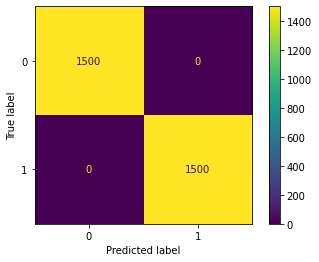

In [ ]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print (classification_report(predictions_labels, flat_true_labels))
cm_test = confusion_matrix(flat_true_labels, predictions_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()

In [ ]:
roberta_model.save_pretrained("/content/drive/MyDrive/RA/roberta-chatgpt-hc3")
roberta_tokenizer.save_pretrained("/content/drive/MyDrive/RA/roberta-chatgpt-hc3-tokenizer")

('/content/drive/MyDrive/RA/roberta-chatgpt-hc3-tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/RA/roberta-chatgpt-hc3-tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/RA/roberta-chatgpt-hc3-tokenizer/vocab.json',
 '/content/drive/MyDrive/RA/roberta-chatgpt-hc3-tokenizer/merges.txt',
 '/content/drive/MyDrive/RA/roberta-chatgpt-hc3-tokenizer/added_tokens.json')

In [ ]:
roberta_model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/RA/roberta-chatgpt-hc3", output_attentions=True)
roberta_tokenizer = RobertaTokenizer.from_pretrained("/content/drive/MyDrive/RA/roberta-chatgpt-hc3-tokenizer")

In [ ]:
roberta_model.to(device)

In [ ]:
def predict_custom_sent(text, model, tokenizer):
  #tokenizing test set
  encoded_dict = tokenizer.encode_plus(
                            str(text),        #sentence
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens
                            max_length = 256,        #Since we have seen from our analysis that majority of sentences have length less than 300.
                            padding = 'max_length',     # Pad sentences to 256 length  if the length of sentence is less than max_length
                            return_attention_mask = True,   # Create attention mask
                            truncation = True,   # truncate sentences to 256 length  if the length of sentence is greater than max_length
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )

  # bert_input_ids_test,bert_attention_masks_test,labels_test = token_dict_test["Bert"]
  input_ids, attention_masks = encoded_dict["input_ids"], encoded_dict["attention_mask"]
  test_dataset = TensorDataset(input_ids, attention_masks)

  sampler = SequentialSampler(test_dataset)
  prediction_dataloader = DataLoader(test_dataset, sampler=sampler, batch_size=32)

  model.eval()
  predictions = []
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch

    with torch.no_grad():

        outputs = roberta_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]


    logits = logits.detach().cpu().numpy()

    # Store predictions and true labels
    predictions.append(logits)

  predictions_labels = [item for subitem in predictions for item in subitem]
  predictions_labels = np.argmax(predictions_labels, axis=1).flatten()
  return "ChatGPT" if predictions_labels[0] == 1 else "Human"

In [ ]:
test_sample = """The sun shines bright, the birds take flight
The world is vast, the day is fast
People rush and hustle, without a bustle
Life goes on, with or without a song."""

In [ ]:
predict_custom_sent(test_sample, roberta_model, roberta_tokenizer)

'ChatGPT'

In [ ]:
test_sample2 = """DQN stands for Deep Q-Network, which is a type of reinforcement learning algorithm used in artificial intelligence. It was developed by Google DeepMind in 2013 and is based on a combination of neural networks and Q-learning, a traditional reinforcement learning algorithm.

In DQN, the agent learns to take actions by estimating the Q-value, which represents the expected future reward for taking a certain action in a given state. The agent's estimate of the Q-value is iteratively improved using a neural network, which is trained to approximate the true Q-value function.

DQN has been applied successfully to a variety of tasks, including playing Atari games and controlling autonomous vehicles. It is considered a significant breakthrough in the field of reinforcement learning and has paved the way for further advances in artificial intelligence."""
predict_custom_sent(test_sample2, roberta_model, roberta_tokenizer)

'ChatGPT'

In [ ]:
test_sample3 = """Hello, Thanks for your query.Even though these three common side effects will diminish over the days and weeksThe most common side effects that people experience after dental implants surgery include:Soreness/discomfort - Many patients will notice some degree of discomfort after surgery is completed. This is natural and occurs following any kind of surgery.Swelling - Swelling is another common surgical side effect. As with soreness, it will dissipate with time.Bruising - Bruising can occur around the gum area simply as a consequence of the surgical procedure. This too will abate with time.I do hope that you have found something helpful and I will be glad to answer any further query.Take care"""
predict_custom_sent(test_sample3, roberta_model, roberta_tokenizer)

'ChatGPT'

In [ ]:
test_sample4 = "Yes radio waves travel at the speed of light . light and radio are basically the same thing : electromagnetic waves and they all travel at the speed of light . Telephone and video conferencing communication around the world usually have small but noticeable lag in them because the data that gets send does not travel at quite the speed of light , takes indirect routes and actually spends quite a bit of time inside devices being processed ."
predict_custom_sent(test_sample3, roberta_model, roberta_tokenizer)

'ChatGPT'

In [ ]:
data_test.text[0]

'Basically there are many categories of " Best Seller " . Replace " Best Seller " by something like " Oscars " and every " best seller " book is basically an " oscar - winning " book . May not have won the " Best film " , but even if you won the best director or best script , you \'re still an " oscar - winning " film . Same thing for best sellers . Also , IIRC the rankings change every week or something like that . Some you might not be best seller one week , but you may be the next week . I guess even if you do n\'t stay there for long , you still achieved the status . Hence , # 1 best seller .'

In [ ]:
data_test.head(10)

,ID,text,label,text_words,text_len
10227,3409_H_0,basically calculus is all to do with calcuatin...,0,"[basically, calculus, is, all, to, do, with, c...",697
8368,8370_C_0,Karma is a way of measuring how much a user ha...,1,"[Karma, is, a, way, of, measuring, how, much, ...",123
79,26_H_1,What I know of my company is that I make much ...,0,"[What, I, know, of, my, company, is, that, I, ...",159
14132,4710_H_2,If you stand in one place and turn around 360 ...,0,"[If, you, stand, in, one, place, and, turn, ar...",97
3301,3301_C_0,A car's maximum speed is the highest speed tha...,1,"[A, car's, maximum, speed, is, the, highest, s...",127
647,647_C_0,Lobotomy is a surgical procedure in which the ...,1,"[Lobotomy, is, a, surgical, procedure, in, whi...",128
5264,1754_H_2,Imaginary numbers are anything but imaginary -...,0,"[Imaginary, numbers, are, anything, but, imagi...",531
4984,1661_H_1,"To buy things or invest in a currency , you ne...",0,"[To, buy, things, or, invest, in, a, currency,...",52
2902,2902_C_0,"In the United States, senators do not have ter...",1,"[In, the, United, States,, senators, do, not, ...",213
4755,4755_C_0,Deep fried ice cream is a dessert that involve...,1,"[Deep, fried, ice, cream, is, a, dessert, that...",197


In [ ]:
predict_custom_sent(data_test.iloc[0].text, roberta_model, roberta_tokenizer)

'Human'

In [ ]:
predict_custom_sent(data_test.iloc[7].text, roberta_model, roberta_tokenizer)

'Human'

In [ ]:
test_sample5 = "Although it is difficult to comment whether Acutret (isotretinoin) needs to be given for rash, I would probably not have prescribed it. The dosage is proper and you need not worry. Do not worry about the warning labels as doctors might have a different thing in mind while prescribing and that correlation might not be apparent to you. No food restrictions needed.For skin rashes, I would probably have prescribed calamine lotion and some antiallergic like fexofenadine for 3-4 days."
predict_custom_sent(test_sample5, roberta_model, roberta_tokenizer)

'ChatGPT'

In [ ]:
test_sample6 = "Welcome and thank you for asking on HCM! I have gone through your question. firstly an ECG is required and if itshows complete heart block (more likely) a pacemaker may beneeded.Hope to have been helpful!Wishing good health, Dr D Sunil Reddy"
predict_custom_sent(test_sample6, roberta_model, roberta_tokenizer)

'ChatGPT'

In [ ]:
test_sample7 = "hiits type of acne.it is difficult to get rid of it but nit impossible.better to consult dermatologistit will take 2-3 month to treat.topical retinoid and isotretinoin have excellent resultbut to be taken after consultation.no face wash will remove it"
predict_custom_sent(test_sample7, roberta_model, roberta_tokenizer)

'ChatGPT'

In [ ]:
test_sample8 = """I feel like I just failed the Swede test , because I legitimately did not know this was going on until you asked . If my explanation sounds too simplistic , it 's because I 'm struggling to understand this as well . Here 's what I 'm getting from the headlines right now : In Husby , a suburb of Stockholm with a high immigrant population ( ~80 % have an " immigrant background " ) , the police shot and killed an old man they claim was threatening to kill them with a machete . The police in the suburbs of Stockholm are often accused of being very racist against immigrants / anyone they think is an immigrant , and this is not the first time fights have broken out , but I think this is the first time they 've broken out on such a large scale . Groups of people , big and small , have been attacking firemen and setting cars on fire . It started on Sunday , and last night they arrested three young guys ( two 18 - year - olds , one 15 - year - old ) for being part of the rioting . They 're all accused of different things , which I 'm struggling to translate , but one 18 year old is being charged with deadly arson and the others of crimes relating to assault . I think the " do n't be racist " mentality is coming from the fact that people are trying to be clear that this is not just ' what happens when you let too many people into our country ' , which is kind of what some sides are saying , but rather that it 's a symptom of a lot of different issues . Also yeah , many Swedes get nervous if you say anything that can be remotely construed as racism , which can make talking about complex issues like this very hard . Some people literally stick their fingers in their ears and refuse to listen the minute you start talking about any sort of issue involving race or the possibility someone ( or some institution , like the Police ) might be racist , no matter what you 're actually saying ."""
predict_custom_sent(test_sample8, roberta_model, roberta_tokenizer)

'Human'

In [ ]:
test_sample9 = """Life insurance is a contract between an insured (insurance policy holder) and an insurer , where the insurer promises to pay a designated beneficiary a sum of money (the "benefits") upon the death of the insured person.Depending on the contract, other events such as terminal illness or critical illness may also trigger payment.Protection policies are designed to provide a benefit in the event of specified event, typically a lump sum payment."""
predict_custom_sent(test_sample9, roberta_model, roberta_tokenizer)

'ChatGPT'

In [ ]:
test_sample10 = """The newest adopted symbol of Arizona is the Colt Single Action Army in 2011.Arizona became the second state to adopt a "state firearm" after Utah adopted the Browning M1911 ."""
predict_custom_sent(test_sample10, roberta_model, roberta_tokenizer)

'Human'

In [ ]:
test_sample11 = """HI,   I understand your concern.    Both  High doses of Ofloxacillin , INH & Ethambutal are placed in catagory c for their use in pregnancy. Though there are no sufficient evidences about their teratogenicirty, they are to be used with precautions in pregnancy when the benefits over weigh the side effects & they are essential for control of Tuberculosis in pregnant woman.    The doses offered to you are in normal range.. & I feel you shoulf believe your treating doctor & continue taking it as per the advise, while regular pregnancy check ups are done.     Thanks."""
predict_custom_sent(test_sample11, roberta_model, roberta_tokenizer)

'ChatGPT'

In [ ]:
!nvidia-smi

Tue Mar 21 01:30:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |  11799MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------